## UTILS

In [24]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class RNN(nn.Module):
    #  TODO:  Implémenter comme décrit dans la question 1
    def __init__(self, dim_input, dim_latent, dim_output):
        super().__init__()
        #self._dim_input = dim_input
        #self._dim_output = dim_output
        self._dim_latent = dim_latent

        self.lin_i = nn.Linear(dim_input, dim_latent, bias=False)
        self.lin_h = nn.Linear(dim_latent, dim_latent, bias=True)
        self.lin_d = nn.Linear(dim_latent, dim_output, bias=True)
        self._tanh = nn.Tanh() 

    def one_step(self,x,h):
        return self._tanh(self.lin_i(x)+ self.lin_h(h) ) 
    
    def forward(self,x):
        l = x.shape[0]
        batch = x.shape[1]
        #l, batch, dim = x.shape
        h = torch.zeros(batch, self._dim_latent)
        sequence = [h] 
        for i in range(l) : 
            hi = self.one_step(x[i], sequence[-1])
            sequence.append(hi)
        return sequence[1:]

    def decode(self, h, type="many-to-one"):
        if type=="many-to-one":
            return self.lin_d(h)
        else : 
            seq = []
            for hi in h: 
                seq.append(self.lin_d(hi))
                
            return torch.stack(seq)
         


class SampleMetroDataset(Dataset):
    def __init__(self, data,length=20,stations_max=None):
        """
            * data : tenseur des données au format  Nb_days x Nb_slots x Nb_Stations x {In,Out}
            * length : longueur des séquences d'exemple
            * stations_max : normalisation à appliquer
        """
        self.data, self.length= data, length
        ## Si pas de normalisation passée en entrée, calcul du max du flux entrant/sortant
        self.stations_max = stations_max if stations_max is not None else torch.max(self.data.view(-1,self.data.size(2),self.data.size(3)),0)[0]
        ## Normalisation des données
        self.data = self.data / self.stations_max
        self.nb_days, self.nb_timeslots, self.classes = self.data.size(0), self.data.size(1), self.data.size(2)

    def __len__(self):
        ## longueur en fonction de la longueur considérée des séquences
        return self.classes*self.nb_days*(self.nb_timeslots - self.length)

    def __getitem__(self,i):
        ## transformation de l'index 1d vers une indexation 3d
        ## renvoie une séquence de longueur length et l'id de la station.
        station = i // ((self.nb_timeslots-self.length) * self.nb_days)
        i = i % ((self.nb_timeslots-self.length) * self.nb_days)
        timeslot = i // self.nb_days
        day = i % self.nb_days
        return self.data[day,timeslot:(timeslot+self.length),station],station

class ForecastMetroDataset(Dataset):
    def __init__(self, data,length=20,stations_max=None):
        """
            * data : tenseur des données au format  Nb_days x Nb_slots x Nb_Stations x {In,Out}
            * length : longueur des séquences d'exemple
            * stations_max : normalisation à appliquer
        """
        self.data, self.length= data,length
        ## Si pas de normalisation passée en entrée, calcul du max du flux entrant/sortant
        self.stations_max = stations_max if stations_max is not None else torch.max(self.data.view(-1,self.data.size(2),self.data.size(3)),0)[0]
        ## Normalisation des données
        self.data = self.data / self.stations_max
        self.nb_days, self.nb_timeslots, self.classes = self.data.size(0), self.data.size(1), self.data.size(2)

    def __len__(self):
        ## longueur en fonction de la longueur considérée des séquences
        return self.nb_days*(self.nb_timeslots - self.length)

    def __getitem__(self,i):
        ## Transformation de l'indexation 1d vers indexation 2d
        ## renvoie x[d,t:t+length-1,:,:], x[d,t+1:t+length,:,:]
        timeslot = i // self.nb_days
        day = i % self.nb_days
        return self.data[day,timeslot:(timeslot+self.length-1)],self.data[day,(timeslot+1):(timeslot+self.length)]



## EXO 2

### cas dim 1

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#from utils import RNN, device,SampleMetroDataset
import matplotlib.pyplot as plt
import numpy as np

# Nombre de stations utilisé
CLASSES = 10
#Longueur des séquences
LENGTH = 20
# Dimension de l'entrée (1 (in) ou 2 (in/out))
DIM_INPUT = 1
#Taille du batch
BATCH_SIZE = 32

PATH = "/home/ubuntu/Documents/Sorbonne/M2/M2-AMAL/TME4/data/"


matrix_train, matrix_test = torch.load(open(PATH+"hzdataset.pch","rb"))
ds_train = SampleMetroDataset(matrix_train[:, :, :CLASSES, :DIM_INPUT], length=LENGTH)
ds_test = SampleMetroDataset(matrix_test[:, :, :CLASSES, :DIM_INPUT], length = LENGTH, stations_max = ds_train.stations_max)
data_train = DataLoader(ds_train,batch_size=BATCH_SIZE,shuffle=True)
data_test = DataLoader(ds_test, batch_size=BATCH_SIZE,shuffle=False)

100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


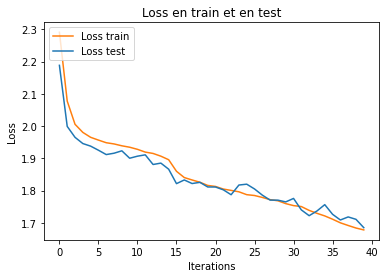

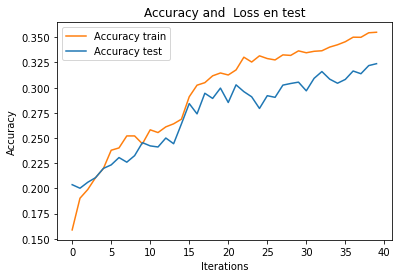

In [26]:
import matplotlib.pyplot as plt

dim_latent = 5
dim_output = CLASSES

epoch = 40
ce = nn.CrossEntropyLoss()
model = RNN(DIM_INPUT, dim_latent, dim_output)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
liste_loss = []
liste_accuracy = []
liste_loss_test = []
liste_accuracy_test = []
for epoch in tqdm(range(epoch)):
    #print("epoch : ", epoch)
    loss_epoch = 0
    accuracy_epoch = 0
    cpt = 0
    e = 0

    for x, y in data_train:
        x = np.transpose(x, (1,0,2))
        optimizer.zero_grad()
        yhat = model(x)
        decode = model.decode(yhat[-1])
        
        loss = ce(decode, y) 
        loss.backward()
        optimizer.step()
        
    
        predicted_labels = torch.argmax(decode, dim=1)
        accuracy = (torch.sum(torch.eq(predicted_labels, y)).item() )/len(y)
        accuracy_epoch += accuracy
        
        loss_epoch += loss.item()
        cpt += 1

    liste_accuracy.append(accuracy_epoch / cpt)
    liste_loss.append(loss_epoch / cpt)


    loss_epoch = 0
    accuracy_epoch = 0
    cpt = 0
    with torch.no_grad() : 
        for x, y in data_test:
            x = np.transpose(x, (1,0,2))
            yhat = model(x)
            decode = model.decode(yhat[-1])
            
            loss = ce(decode, y) 
            predicted_labels = torch.argmax(decode, dim=1)
            accuracy = (torch.sum(torch.eq(predicted_labels, y)).item() )/len(y)
            accuracy_epoch += accuracy
            
            loss_epoch += loss.item()
            cpt += 1

    liste_accuracy_test.append(accuracy_epoch / cpt)
    liste_loss_test.append(loss_epoch / cpt)




plt.figure()
plt.plot(np.arange(len(liste_loss)), liste_loss, label='Loss train', color='tab:orange')
plt.xlabel("Iterations")
plt.plot(np.arange(len(liste_loss_test)), liste_loss_test, label='Loss test', color='tab:blue')
plt.ylabel("Loss")
plt.title("Loss en train et en test")
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(np.arange(len(liste_accuracy)), liste_accuracy, label='Accuracy train', color='tab:orange')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(np.arange(len(liste_accuracy_test)), liste_accuracy_test, label='Accuracy test', color='tab:blue')
plt.title("Accuracy and  Loss en test")
plt.legend(loc='upper left')
plt.show()

## Cas dim 2

In [27]:
# Nombre de stations utilisé
CLASSES = 10
#Longueur des séquences
LENGTH = 20
# Dimension de l'entrée (1 (in) ou 2 (in/out))
DIM_INPUT = 2
#Taille du batch
BATCH_SIZE = 32

PATH = "/home/ubuntu/Documents/Sorbonne/M2/M2-AMAL/TME4/data/"


matrix_train, matrix_test = torch.load(open(PATH+"hzdataset.pch","rb"))
ds_train = SampleMetroDataset(matrix_train[:, :, :CLASSES, :DIM_INPUT], length=LENGTH)
ds_test = SampleMetroDataset(matrix_test[:, :, :CLASSES, :DIM_INPUT], length = LENGTH, stations_max = ds_train.stations_max)
data_train = DataLoader(ds_train,batch_size=BATCH_SIZE,shuffle=True)
data_test = DataLoader(ds_test, batch_size=BATCH_SIZE,shuffle=False)

100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


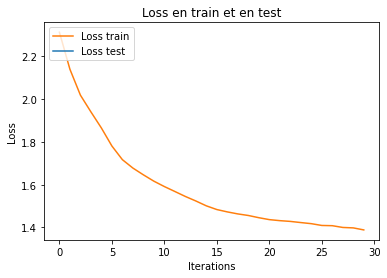

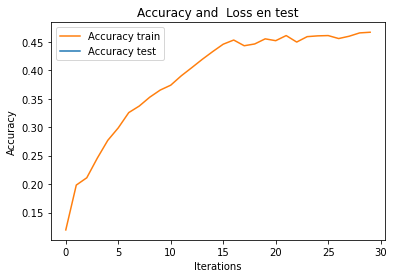

In [28]:
import matplotlib.pyplot as plt

dim_latent = 5
dim_output = CLASSES

epoch = 30
ce = nn.CrossEntropyLoss()
model = RNN(DIM_INPUT, dim_latent, dim_output)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
liste_loss = []
liste_accuracy = []
liste_loss_test = []
liste_accuracy_test = []
for epoch in tqdm(range(epoch)):
    loss_epoch = 0
    accuracy_epoch = 0
    cpt = 0

    for x, y in data_train:
        x = np.transpose(x, (1,0,2))
        optimizer.zero_grad()
        yhat = model(x)
        decode = model.decode(yhat[-1])
        
        loss = ce(decode, y) 
        loss.backward()
        optimizer.step()
        
    
        predicted_labels = torch.argmax(decode, dim=1)
        accuracy = (torch.sum(torch.eq(predicted_labels, y)).item() )/len(y)
        accuracy_epoch += accuracy
        
        loss_epoch += loss.item()
        cpt += 1

    liste_accuracy.append(accuracy_epoch / cpt)
    liste_loss.append(loss_epoch / cpt)

    """
    loss_epoch = 0
    accuracy_epoch = 0
    cpt = 0
    with torch.no_grad():
        for x, y in data_test:
            x = np.transpose(x, (1,0,2))
            yhat = model(x)
            decode = model.decode(yhat[-1])
            
            loss = ce(decode, y) 
            predicted_labels = torch.argmax(decode, dim=1)
            accuracy = (torch.sum(torch.eq(predicted_labels, y)).item() )/len(y)
            accuracy_epoch += accuracy
            
            loss_epoch += loss.item()
            cpt += 1

    liste_accuracy_test.append(accuracy_epoch / cpt)
    liste_loss_test.append(loss_epoch / cpt)
    """



plt.figure()
plt.plot(np.arange(len(liste_loss)), liste_loss, label='Loss train', color='tab:orange')
plt.xlabel("Iterations")
plt.plot(np.arange(len(liste_loss_test)), liste_loss_test, label='Loss test', color='tab:blue')
plt.ylabel("Loss")
plt.title("Loss en train et en test")
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(np.arange(len(liste_accuracy)), liste_accuracy, label='Accuracy train', color='tab:orange')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(np.arange(len(liste_accuracy_test)), liste_accuracy_test, label='Accuracy test', color='tab:blue')
plt.title("Accuracy and  Loss en test")
plt.legend(loc='upper left')
plt.show()

# Exercice 3 

In [29]:
from torch.utils.data import  DataLoader
import torch
import matplotlib.pyplot as plt

# Nombre de stations utilisé
CLASSES = 10
#Longueur des séquences
LENGTH = 20
# Dimension de l'entrée (1 (in) ou 2 (in/out))
DIM_INPUT = 2
#Taille du batch
BATCH_SIZE = 32

PATH = "/home/ubuntu/Documents/Sorbonne/M2/M2-AMAL/TME4/data/"


matrix_train, matrix_test = torch.load(open(PATH+"hzdataset.pch", "rb"))
ds_train = ForecastMetroDataset(
    matrix_train[:, :, :CLASSES, :DIM_INPUT], length=LENGTH)
ds_test = ForecastMetroDataset(
    matrix_test[:, :, :CLASSES, :DIM_INPUT], length=LENGTH, stations_max=ds_train.stations_max)
data_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
data_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

#  TODO:  Question 3 : Prédiction de séries temporelles


  0%|          | 0/30 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2, 320, 2])) that is different to the input size (torch.Size([320, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2, 260, 2])) that is different to the input size (torch.Size([260, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2, 190, 2])) that is different to the input size (torch.Size([190, 2])). This will likely lead to incorrect resul

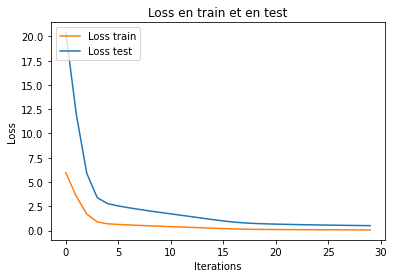

In [30]:

dim_latent = 5
dim_output = CLASSES

pas = 2

epoch = 30
mse = nn.MSELoss()
model = RNN(DIM_INPUT, dim_latent, DIM_INPUT)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
liste_loss = []
liste_loss_test = []
for epoch in tqdm(range(epoch)):
    loss_epoch = 0
    accuracy_epoch = 0
    cpt = 0

    for x,_ in data_train:
        x = np.transpose(x, (1,0,2,3))
        x = x.reshape(x.shape[0], -1, DIM_INPUT)

        optimizer.zero_grad()

        loss = 0
        h = torch.zeros((  x.shape[1], dim_latent))
        for l in range(x.shape[0]-pas):
            h = model.one_step(x[l], h)
            ht = h
            pred = torch.zeros(( pas, x.shape[1], DIM_INPUT))
            for p in range(pas):
                ht = model.one_step(x[l+p+1], h)
                decode = model.decode(ht)
                pred[p] = decode        

            y = x[l+1:l+pas+1]

            loss += mse(decode, y)

        loss.backward()
        optimizer.step()
                    
        loss_epoch += loss.item()
        cpt += 1

    liste_loss.append(loss_epoch / cpt)


    accuracy_epoch = 0
    cpt = 0

    for x,_ in data_test:
        x = np.transpose(x, (1,0,2,3))
        x = x.reshape(x.shape[0], -1, DIM_INPUT)

        optimizer.zero_grad()

        loss = 0
        with torch.no_grad():
            h = torch.zeros((  x.shape[1], dim_latent))
            for l in range(x.shape[0]-pas):
                h = model.one_step(x[l], h)
                ht = h
                pred = torch.zeros(( pas, x.shape[1], DIM_INPUT))
                for p in range(pas):
                    ht = model.one_step(x[l+p+1], ht)
                    decode = model.decode(h)
                    pred[p] = decode        

                y = x[l+1:l+pas+1]

                loss += mse(decode, y)

        optimizer.step()
                    
        loss_epoch += loss.item()
        cpt += 1
    liste_loss_test.append(loss_epoch / cpt)



plt.figure()
plt.plot(np.arange(len(liste_loss)), liste_loss, label='Loss train', color='tab:orange')
plt.xlabel("Iterations")
plt.plot(np.arange(len(liste_loss_test)), liste_loss_test, label='Loss test', color='tab:blue')
plt.ylabel("Loss")
plt.title("Loss en train et en test")
plt.legend(loc='upper left')
plt.show()



# Exercice 4

In [31]:
import string
import unicodedata
import torch
import sys
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset,DataLoader

#from utils import RNN, device

#Taille du batch
BATCH_SIZE = 32

PATH = "/home/ubuntu/Documents/Sorbonne/M2/M2-AMAL/TME4/data/"

## Liste des symboles autorisés
LETTRES = string.ascii_letters + string.punctuation+string.digits+' '
## Dictionnaire index -> lettre
id2lettre = dict(zip(range(1,len(LETTRES)+1),LETTRES))
id2lettre[0]='' ##NULL CHARACTER
## Dictionnaire lettre -> index
lettre2id = dict(zip(id2lettre.values(),id2lettre.keys()))


def normalize(s):
    """ Nettoyage d'une chaîne de caractères. """
    return ''.join(c for c in unicodedata.normalize('NFD', s) if  c in LETTRES)

def string2code(s):
    """ Transformation d'une chaîne de caractère en tenseur d'indexes """
    return torch.tensor([lettre2id[c] for c in normalize(s)])

def code2string(t):
    """ Transformation d'une liste d'indexes en chaîne de caractères """
    if type(t) !=list:
        t = t.tolist()
    return ''.join(id2lettre[i] for i in t)

class TrumpDataset(Dataset):
    def __init__(self,text,maxsent=None,maxlen=None):
        """  Dataset pour les tweets de Trump
            * text : texte brut
            * maxsent : nombre maximum de phrases.
            * maxlen : longueur maximale des phrases.
        """
        maxlen = maxlen or sys.maxsize
        full_text = normalize(text)
        self.phrases = [p[:maxlen].strip()+"." for p in full_text.split(".") if len(p)>0]
        if maxsent is not None:
            self.phrases=self.phrases[:maxsent]
        self.MAX_LEN = max([len(p) for p in self.phrases])

    def __len__(self):
        return len(self.phrases)
    
    def __getitem__(self,i):
        t = string2code(self.phrases[i])
        t = torch.cat([torch.zeros(self.MAX_LEN-t.size(0),dtype=torch.long),t])
        return t[:-1],t[1:]



#  TODO: 

data_trump = DataLoader(TrumpDataset(open(PATH+"trump_full_speech.txt","rb").read().decode(),maxlen=100), batch_size= BATCH_SIZE
, shuffle=True)


In [32]:
def one_hot(x, num_classes):
    one_hot = torch.nn.functional.one_hot(x, num_classes=num_classes)
    return one_hot.to(torch.float)
    

100%|██████████| 10/10 [03:13<00:00, 19.39s/it]


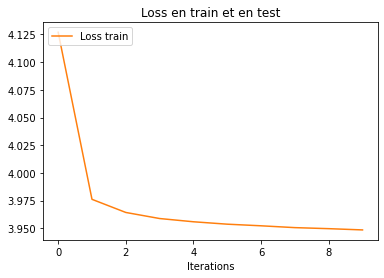

In [35]:
import matplotlib.pyplot as plt

dim_input = len(LETTRES)+1
dim_latent = 50
dim_output = 100


epoch = 10
embeding = nn.Linear(dim_input, dim_input)
rnn = RNN(dim_input, dim_latent, dim_input)

params = list(rnn.parameters()) + list(embeding.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)


liste_loss = []
liste_loss_test = []
for epoch in tqdm(range(epoch)):
    
    liste_loss_tmp = []

    for x,y in data_trump:
        x_one_hot = one_hot(x, dim_input)
        x_emb = embeding(x_one_hot)

        y_one_hot = one_hot(y, dim_input)

        optimizer.zero_grad()

        liste_h  = rnn(x_emb) 
        yhat = rnn.decode(liste_h, "many-to-many")

        loss = criterion(yhat, y_one_hot)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            liste_loss_tmp.append(loss.item())
        
    liste_loss.append(np.mean(liste_loss_tmp))
    
plt.figure()
plt.plot(np.arange(len(liste_loss)), liste_loss, label='Loss train', color='tab:orange')
plt.xlabel("Iterations")
plt.title("Loss en train et en test")
plt.legend(loc='upper left')
plt.show()


In [36]:
debut = 'hello'
sentence = debut

debut = string2code(debut)
debut = one_hot(debut, dim_input)
debut = embeding(debut)

h_i = rnn(debut)
h_i = torch.stack(h_i)
yhat = rnn.decode(h_i,type='many-to-many')
yhat = yhat.softmax(dim=2)

x_i = torch.multinomial(yhat[0,0,:],1)
x_i = one_hot(x_i, dim_input)
#x_i = embeding(x_i)
sentence += code2string([torch.argmax(x_i).item()])

for _ in range(dim_output):
    h_i = rnn.one_step(x_i,h_i)
    yhat = rnn.decode(h_i,type='many-to-one').softmax(dim=2)
    x_i = torch.multinomial(yhat[0,0,:],1)
    x_i = one_hot(x_i, dim_input)
   # x_i = embeding(x_i)
    sentence += code2string([torch.argmax(x_i).item()])

sentence



"helloaEGSQO5>9ihstn1 g]!k-xAk_g]Fx ;'-svel]rZQcy]g9i]n<scltk2<rt'nicdkskexo`hu0p'lkkwVe]pS,f'']rx!Dpdiegyl"